In [ ]:
"""
Transform accumulated changes from fMRI layers into durations (s) using
multiclass SVM
"""

'\nTransform accumulated changes from fMRI layers into durations (s) using\nmulticlass SVM\n'

# IMPORT LIBS AND DATA

In [1]:
from sklearn.svm import SVR
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from math import sqrt
import scipy.io as sio
import scipy.stats as stats
from scipy import signal
import os.path as op
import os
from sklearn.base import clone
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import chi2
import glob
from time import time
import statistics
import seaborn as sns
from IPython.display import clear_output

#Device configuration
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
#from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import scipy.stats as stats
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

outdir = 'D:\\ERICK\\MD\\prediction_data\\'
datadir = 'D:\\ERICK\\MD\\'
load_file = op.join(datadir, 'master_dataset.csv')
data = pd.read_csv(load_file)

# SVM

In [ ]:
#create training data from salient events
resdir = 'D:\\ERICK\\MD\\Results\\'
excluded = [41, 45]
regions = ['rNet1', 'rNet2', 'rNet3', 'rNet6', 'rNet7', 'rNet8', 'rNet11', 'rNet1+11']
netKey = {
    'rNet1': 'vis',
    'rNet2': 'smn',
    'rNet3': 'cing',
    'rNet6': 'dmn',
    'rNet7': 'fpn',
    'rNet8': 'aud',
#     'rNet9': 'aud2',
    'rNet11': 'dan',
    'rNet1+11': 'vis+dan'
}
dfs = {}

new_id = 1
for subject in range(4, 45):
    if subject in excluded:
        continue
        
    for region in regions:
        data_net = {'subj': [], 'duration': [], 'isCity': [], 'report': [], 'humanBias': [], 'estimationError': []}
        datafile = op.join(resdir, str(subject), 'accum_changes_{}.mat'.format(region))
        if op.isfile(datafile):

            df = sio.loadmat(datafile)
            df = df['d'][0][0]
            h = len(df[0])
            hb = data.loc[data['rawSubjID']==subject, 'humanBias']
            error = data.loc[data['rawSubjID']==subject, 'estimationError']

            data_net['subj'].extend([new_id] * h)
            data_net['duration'].extend(df[4].reshape(h))
            data_net['isCity'].extend(df[2].reshape(h))
            data_net['report'].extend(df[1].reshape(h))
            data_net['humanBias'].extend(hb)
            data_net['estimationError'].extend(error)
            data_net['acc_se'] = df[0].reshape(h)

        # Use o nome da região para criar o DataFrame
        if region not in dfs:
            dfs[region] = []
            dfs[region].append(pd.DataFrame(data_net))
        else:
            dfs[region].append(pd.DataFrame(data_net))

    if op.isfile(datafile):
        new_id = new_id + 1

for i in dfs:
    dfs[i] = pd.concat(dfs[i], ignore_index=True)

# df_visual = pd.concat(df_visual, ignore_index=True)
# df_auditory = pd.concat(df_auditory, ignore_index=True)
# df_somatosensory = pd.concat(df_somatosensory, ignore_index=True)

In [ ]:
#save dataframes
for region in regions:
    print(region)
    save_path = op.join(outdir,'{}.csv'.format(netKey[region]))
    print(save_path)
    df = pd.DataFrame(dfs[region])
#     print(df)
    df.to_csv(save_path, sep=',', encoding='utf-8')

rNet1
D:\ERICK\MD\prediction_data\vis.csv
rNet2
D:\ERICK\MD\prediction_data\smn.csv
rNet3
D:\ERICK\MD\prediction_data\cing.csv
rNet6
D:\ERICK\MD\prediction_data\dmn.csv
rNet7
D:\ERICK\MD\prediction_data\fpn.csv
rNet8
D:\ERICK\MD\prediction_data\aud.csv
rNet11
D:\ERICK\MD\prediction_data\dan.csv
rNet1+11
D:\ERICK\MD\prediction_data\vis+dan.csv


In [ ]:
files = ['vis', 'smn', 'cing', 'dmn', 'fpn', 'aud', 'dan', 'vis+dan']

columns = ['Região', 'r (Pearson)', 'p-value']
df = pd.DataFrame(columns=columns)

for region in files:
    print(region)
    load_file = op.join(outdir, '{}.csv'.format(region))
    save_file = op.join(outdir, 'predicted_{}.csv'.format(region))
    data = pd.read_csv(load_file, sep=',')
    accumulated_changes = np.array(data.acc_se).reshape(-1, 1)
    duration=np.ravel(data.duration)
    regressor = SVR(kernel='rbf', C=1e3, gamma=0.0001)
    regressor.fit(accumulated_changes, duration)
    predicted = regressor.predict(accumulated_changes)
    output    = np.array(pd.concat([data.subj,data.duration,data.isCity,data.report, data.humanBias,
                                    pd.Series(predicted), data.acc_se],axis=1))
    output = pd.DataFrame(output, columns=['subj', 'duration', 'isCity', 'report', 'humanBias', 'predicted', 'acc_se'])
    output.to_csv(save_file, sep=',', encoding='utf-8')

    # 10-fold cross val
    j = 0
    kf = KFold(n_splits=10, shuffle=True)
    rmse, rho, p = np.zeros(10), np.zeros(10), np.zeros(10)

    for train_index, test_index in kf.split(accumulated_changes):
        X_train, X_test = accumulated_changes[train_index], accumulated_changes[test_index]
        Y_train, Y_test = duration[train_index], duration[test_index]

        regressor.fit(X_train, Y_train)
        preds = regressor.predict(X_test)

        rho[j], p[j] = stats.pearsonr(np.ravel(preds), np.ravel(Y_test))
        rmse[j] = sqrt(mean_squared_error(Y_test, preds))
        j += 1

    mean_rho = np.round(np.mean(rho[rho != 0]), 2)
    mean_p = np.round(np.mean(p[p != 0]), 2)
    linha = [region, mean_rho, mean_p]
    df.loc[len(df)] = linha

    print(f'r = {np.mean(rho[rho != 0]):.3f}, p = {np.mean(p[p != 0]):.3f}')
    print(f'RMSE is: {np.mean(rmse[rmse != 0]):.3f}')

outFile = op.join(outdir, 'svr_table.csv')
df.to_csv(outFile, sep=',', encoding='utf-8')

vis
r = 0.949, p = 0.000
RMSE is: 1.778
smn
r = 0.955, p = 0.000
RMSE is: 1.706
cing
r = 0.954, p = 0.000
RMSE is: 1.748
dmn
r = 0.954, p = 0.000
RMSE is: 1.733
fpn
r = 0.951, p = 0.000
RMSE is: 1.767
aud
r = 0.957, p = 0.000
RMSE is: 1.642
dan
r = 0.952, p = 0.000
RMSE is: 1.743
vis+dan
r = 0.947, p = 0.000
RMSE is: 1.814


# FIG 5

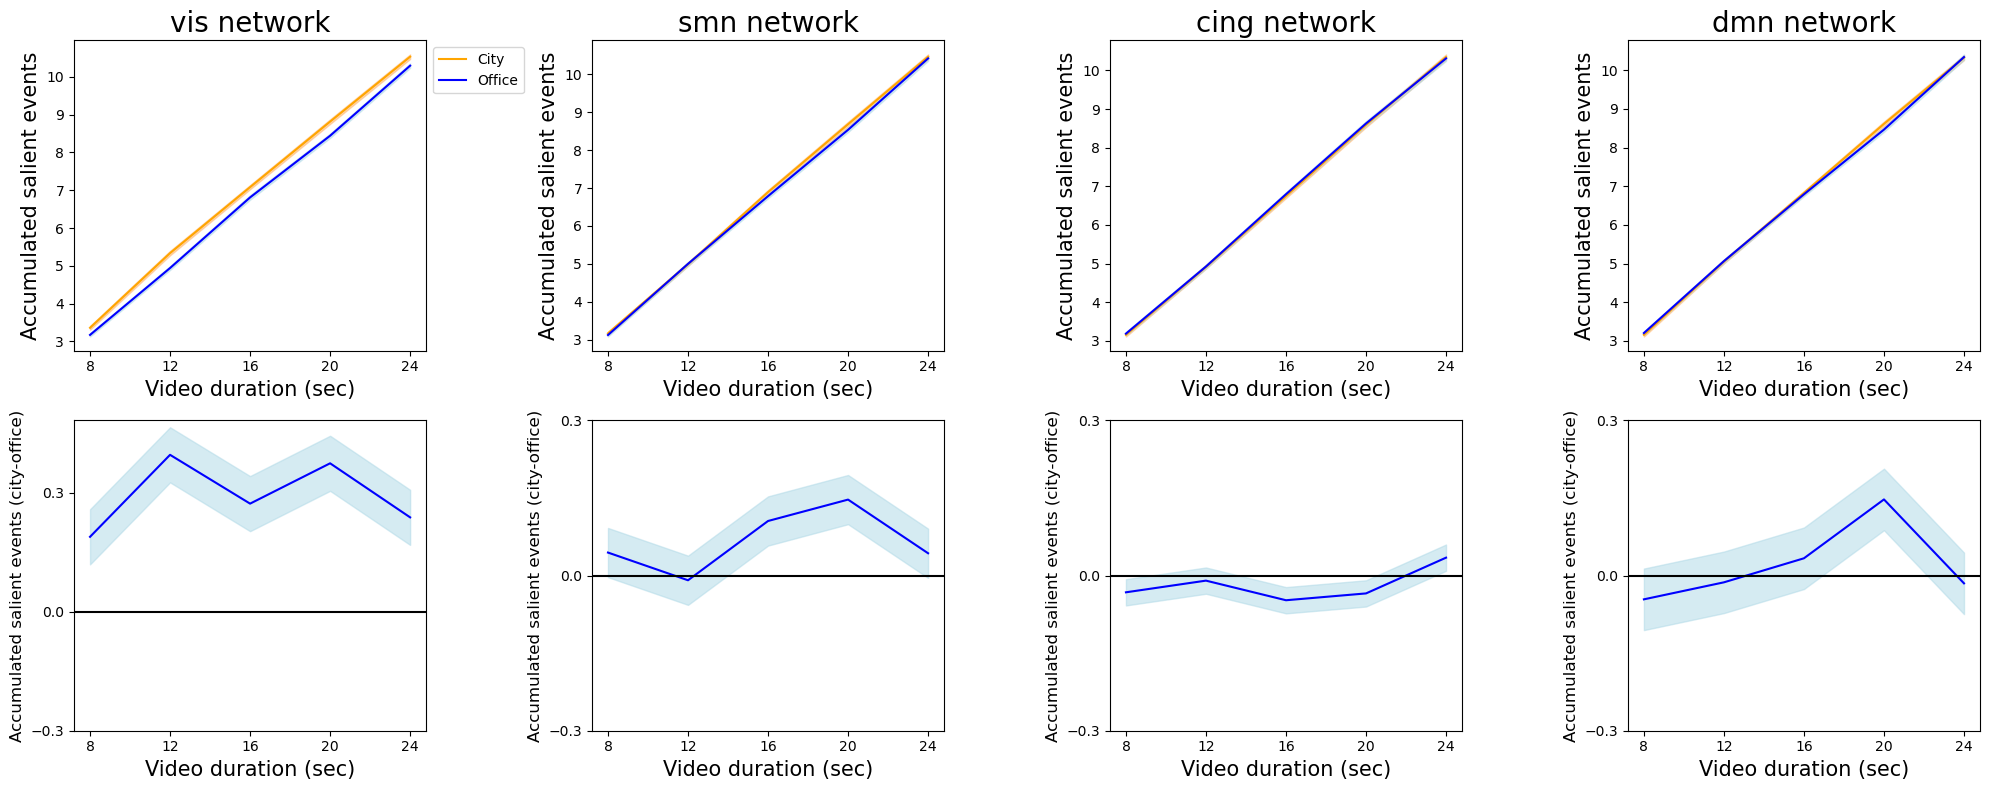

In [71]:
#plotting fig5
#left
files = ['vis', 'smn', 'cing', 'dmn']
durations = [8, 12, 16, 20, 24]

# Plotar gráficos para cada região
fig, axs = plt.subplots(2, len(files), figsize=(5 * len(files), 8))

for i, region in enumerate(files):
    load_file = op.join(outdir, '{}.csv'.format(region))
    data = pd.read_csv(load_file)
    subcity = data[data['isCity'] == 1]
    suboff = data[data['isCity'] == 0]

    # Gráficos 'left'
    SE_city_left = subcity.groupby('duration')['acc_se'].mean().tolist()
    sem_c_left = subcity.groupby('duration')['acc_se'].sem().tolist()
    SE_off_left = suboff.groupby('duration')['acc_se'].mean().tolist()
    sem_o_left = suboff.groupby('duration')['acc_se'].sem().tolist()

    chart_left = axs[0, i]
    chart_left.plot(durations, SE_city_left, color='orange', label='City')
    chart_left.plot(durations, SE_off_left, color='blue', label='Office')
#     chart_left.legend(loc='upper left')

    # Plot SEM 'left'
    lbound_c_left = [a - b for a, b in zip(SE_city_left, sem_c_left)]
    ubound_c_left = [a + b for a, b in zip(SE_city_left, sem_c_left)]
    lbound_o_left = [a - b for a, b in zip(SE_off_left, sem_o_left)]
    ubound_o_left = [a + b for a, b in zip(SE_off_left, sem_o_left)]
    custom_color = (1.0, 0.7, 0.4)
    chart_left.fill_between(durations, lbound_c_left, ubound_c_left, color=custom_color, alpha=0.5)
    chart_left.fill_between(durations, lbound_o_left, ubound_o_left, color='lightblue', alpha=0.5)

    chart_left.set_title(f'{region} network', fontsize=20)
    chart_left.set_xlabel('Video duration (sec)', fontsize=15)
    chart_left.set_ylabel('Accumulated salient events', fontsize=15)
    chart_left.set_xticks(durations)

    # Gráficos 'right'
    SE_city_right = subcity.groupby('duration')['acc_se'].mean().tolist()
    SE_off_right = suboff.groupby('duration')['acc_se'].mean().tolist()
    diff_right = np.array(SE_city_right) - np.array(SE_off_right)

    chart_right = axs[1, i]
    chart_right.plot(durations, diff_right, color='blue', label='City-Office')

    # Cálculo dos limites do intervalo de confiança 'right'
    n_right = len(diff_right)  # Tamanho da amostra
    z_right = 1.96  # Valor crítico para um intervalo de confiança de 95%
    lower_bound_right = diff_right - (z_right * np.std(diff_right) / np.sqrt(n_right))
    upper_bound_right = diff_right + (z_right * np.std(diff_right) / np.sqrt(n_right))
    # Preenchimento do intervalo de confiança 'right'
    chart_right.fill_between(durations, lower_bound_right, upper_bound_right, color='lightblue', alpha=0.5)
    chart_right.set_yticks([-0.3, 0, 0.3])

    chart_right.axhline(0, color='black')
    chart_right.set_xlabel('Video duration (sec)', fontsize=15)
    chart_right.set_ylabel('Accumulated salient events (city-office)', fontsize=12)
    chart_right.set_xticks(durations)

# Adicionar legenda apenas ao primeiro gráfico da primeira linha
axs[0, 0].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Ajustar layout e exibir a figura
plt.tight_layout()
plt.show()

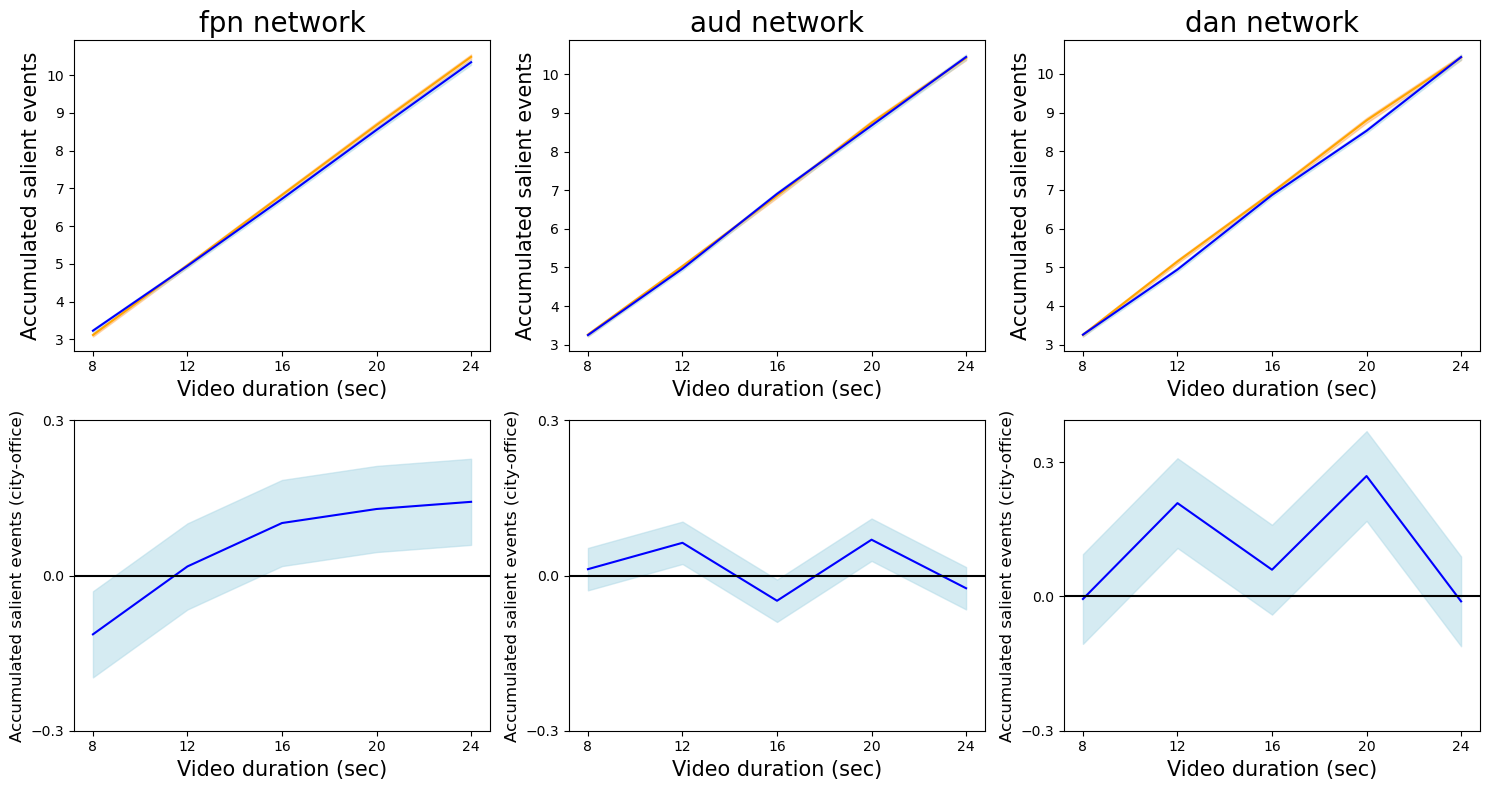

In [70]:
files = ['fpn', 'aud', 'dan']
durations = [8, 12, 16, 20, 24]

# Plotar gráficos para cada região
fig, axs = plt.subplots(2, len(files), figsize=(5 * len(files), 8))

for i, region in enumerate(files):
    load_file = op.join(outdir, '{}.csv'.format(region))
    data = pd.read_csv(load_file)
    subcity = data[data['isCity'] == 1]
    suboff = data[data['isCity'] == 0]

    # Gráficos 'left'
    SE_city_left = subcity.groupby('duration')['acc_se'].mean().tolist()
    sem_c_left = subcity.groupby('duration')['acc_se'].sem().tolist()
    SE_off_left = suboff.groupby('duration')['acc_se'].mean().tolist()
    sem_o_left = suboff.groupby('duration')['acc_se'].sem().tolist()

    chart_left = axs[0, i]
    chart_left.plot(durations, SE_city_left, color='orange', label='City')
    chart_left.plot(durations, SE_off_left, color='blue', label='Office')
#     chart_left.legend(loc='upper left')

    # Plot SEM 'left'
    lbound_c_left = [a - b for a, b in zip(SE_city_left, sem_c_left)]
    ubound_c_left = [a + b for a, b in zip(SE_city_left, sem_c_left)]
    lbound_o_left = [a - b for a, b in zip(SE_off_left, sem_o_left)]
    ubound_o_left = [a + b for a, b in zip(SE_off_left, sem_o_left)]
    custom_color = (1.0, 0.7, 0.4)
    chart_left.fill_between(durations, lbound_c_left, ubound_c_left, color=custom_color, alpha=0.5)
    chart_left.fill_between(durations, lbound_o_left, ubound_o_left, color='lightblue', alpha=0.5)

    chart_left.set_title(f'{region} network', fontsize=20)
    chart_left.set_xlabel('Video duration (sec)', fontsize=15)
    chart_left.set_ylabel('Accumulated salient events', fontsize=15)
    chart_left.set_xticks(durations)
    
    # Gráficos 'right'
    SE_city_right = subcity.groupby('duration')['acc_se'].mean().tolist()
    SE_off_right = suboff.groupby('duration')['acc_se'].mean().tolist()
    diff_right = np.array(SE_city_right) - np.array(SE_off_right)

    chart_right = axs[1, i]
    chart_right.plot(durations, diff_right, color='blue', label='City-Office')

    # Cálculo dos limites do intervalo de confiança 'right'
    n_right = len(diff_right)  # Tamanho da amostra
    z_right = 1.96  # Valor crítico para um intervalo de confiança de 95%
    lower_bound_right = diff_right - (z_right * np.std(diff_right) / np.sqrt(n_right))
    upper_bound_right = diff_right + (z_right * np.std(diff_right) / np.sqrt(n_right))
    # Preenchimento do intervalo de confiança 'right'
    chart_right.fill_between(durations, lower_bound_right, upper_bound_right, color='lightblue', alpha=0.5)
    chart_right.set_yticks([-0.3, 0, 0.3])

    chart_right.axhline(0, color='black')
    chart_right.set_xlabel('Video duration (sec)', fontsize=15)
    chart_right.set_ylabel('Accumulated salient events (city-office)', fontsize=12)
    chart_right.set_xticks(durations)

# Adicionar legenda apenas ao primeiro gráfico da primeira linha
# axs[0, 0].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Ajustar layout e exibir a figura
plt.tight_layout()
plt.show()

# MODEL BIAS

In [ ]:
#calculate model bias for each subject
files = ['vis', 'smn', 'cing', 'dmn', 'fpn', 'aud', 'dan', 'vis+dan']
durations = [8, 12, 16, 20, 24]
dur_dic = {8:0, 12:1, 16:2, 20:3, 24:4}
modelBias_off = {'vis':[], 'smn':[], 'cing':[], 'dmn':[], 'fpn':[], 'aud':[], 'dan':[], 'vis+dan':[]}
modelBias_city = {'vis':[], 'smn':[], 'cing':[], 'dmn':[], 'fpn':[], 'aud':[], 'dan':[], 'vis+dan':[]}
avgmb_diff = {'vis':[], 'smn':[], 'cing':[], 'dmn':[], 'fpn':[], 'aud':[], 'dan':[], 'vis+dan':[]}
modelBias_all = {'vis':[], 'smn':[], 'cing':[], 'dmn':[], 'fpn':[], 'aud':[], 'dan':[], 'vis+dan':[]}
avgmb_all = {'vis':[], 'smn':[], 'cing':[], 'dmn':[], 'fpn':[], 'aud':[], 'dan':[], 'vis+dan':[]}
avgmb_c = {'vis':[], 'smn':[], 'cing':[], 'dmn':[], 'fpn':[], 'aud':[], 'dan':[], 'vis+dan':[]}
avgmb_o = {'vis':[], 'smn':[], 'cing':[], 'dmn':[], 'fpn':[], 'aud':[], 'dan':[], 'vis+dan':[]}
n = 40  # Tamanho da amostra
# outdir = 'D:\\ERICK\\MD\\predictions (ORIGINAL)\\'

overwrite = False

for region in files:
    print(region)
    load_file = op.join(outdir, 'predicted_{}.csv'.format(region))
    data = pd.read_csv(load_file)
    for subj in range(1, 39):
        subset_c = data.loc[(data['subj'] == subj) & (data['isCity'] == 1)]
        subset_o = data.loc[(data['subj'] == subj) & (data['isCity'] == 0)]
        subset = data.loc[(data['subj'] == subj)]
        mb_subcity = []
        mb_suboff = []
        mb_suball = []

        for dur in durations:
            mean_dur = subset.groupby('duration')['predicted'].mean().tolist()
        for ind, row in subset.iterrows():
            modelrep = row['predicted']
            md_idx = dur_dic[row['duration']]
            model_bias = 100*(modelrep-mean_dur[md_idx])/mean_dur[md_idx]
            mb_suball.append(model_bias)
            modelBias_all[region].append(model_bias)
        for ind, row in subset_c.iterrows():
            modelrep = row['predicted']
            md_idx = dur_dic[row['duration']]
            model_bias = 100*(modelrep-mean_dur[md_idx])/mean_dur[md_idx]
            mb_subcity.append(model_bias)
            modelBias_city[region].append(model_bias)
        for ind, row in subset_o.iterrows():
            modelrep = row['predicted']
            md_idx = dur_dic[row['duration']]
            model_bias = 100*(modelrep-mean_dur[md_idx])/mean_dur[md_idx]
            mb_suboff.append(model_bias)
            modelBias_off[region].append(model_bias)
        #calculate diff
        diff = np.mean(mb_subcity)-np.mean(mb_suboff)
        avgmb_diff[region].append(diff)
        #average within subject
        avgmb_c[region].append(np.mean(mb_subcity))
        avgmb_o[region].append(np.mean(mb_suboff))
        avgmb_all[region].append(np.mean(mb_suball))

    #overwrite file
    if overwrite:
        data['modelBias'] = modelBias_all[region]
        data.to_csv(load_file, sep=',', encoding='utf-8')

vis
smn
cing
dmn
fpn
aud
dan
vis+dan


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import scipy

# outdir = 'D:\\ERICK\\MD\\predictions (ORIGINAL)\\'
files = ['vis', 'smn', 'cing', 'dmn', 'fpn', 'aud', 'dan', 'vis+dan']
stats = []

columns = ['Region', 'Duration bias', '95% CI', 'chi-squared', 'p-value']
df = pd.DataFrame(columns=columns)

for region in files:
    print('------------------------------')
    print(region)
    model_file = op.join(outdir, 'predicted_{}.csv'.format(region))
    model_data = pd.read_csv(model_file)
    #plot model bias hist
#     plt.hist(model_data['modelBias'])
#     plt.show()

    #Regressão => bias (human) = B0 + B1 * bias (model)
    x = model_data['modelBias']
    y = model_data['humanBias']
    #corr
    rho,p = scipy.stats.spearmanr(x, y)
    print('Correlation between human and model bias: r = {:.2f}, p = {:.3f}'
          .format(rho, p))
    modelo = sm.OLS(y, sm.add_constant(x)).fit()
    print('Linear Regression between human and model bias: beta = {:.2f} ± {:.2f}, p = {:.3f}'
          .format(modelo.params[1], modelo.bse[1], modelo.f_pvalue))

#     EFEITO FIXO = MODEL BIAS
    vc = {'subj': '1 + C(subj)'}
    # Ajustar o modelo reduzido sem o efeito fixo
    model_reduced = sm.MixedLM.from_formula("humanBias ~ 1", vc_formula=vc, data=model_data, groups=model_data['subj'])
    result_reduced = model_reduced.fit()
    # Ajustar o modelo completo com o efeito fixo
    model_full = sm.MixedLM.from_formula("humanBias ~ 1 + modelBias", vc_formula=vc, data=model_data, groups=model_data['subj'])
    result_full = model_full.fit()
    # Calcular a diferença nas log-verossimilhanças
    llf_full = result_full.llf
    llf_reduced = result_reduced.llf
    lrt = -2 * (llf_reduced - llf_full)
    # Calcular o valor p do teste
    p_value = chi2.sf(lrt, 1)
    print('Using model bias as fixed effect: chi-sqr = {:.2f}, p = {:.3f}'
          .format(lrt, p_value))

    #EFEITO FIXO = CENA
    vc = {'subj': '1 + C(subj)'}
    # Ajustar o modelo reduzido sem o efeito fixo
    model_reduced = sm.MixedLM.from_formula("modelBias ~ 1", vc_formula=vc, data=model_data, groups=model_data['subj'])
    result_reduced = model_reduced.fit()
    # Ajustar o modelo completo com o efeito fixo
    model_full = sm.MixedLM.from_formula("modelBias ~ 1 + isCity", vc_formula=vc, data=model_data, groups=model_data['subj'])
    result_full = model_full.fit()
    # Calcular a diferença nas log-verossimilhanças
    llf_full = result_full.llf
    llf_reduced = result_reduced.llf
    lrt = np.round(-2 * (llf_reduced - llf_full), 2)
    # Calcular o valor p do teste
    p_value = np.round(chi2.sf(lrt, 1), 3)
    #calculate and print statistics
    mean = np.round(np.mean(avgmb_diff[region]), 2)
    SE = np.round(np.std(avgmb_diff[region], ddof=1)/np.sqrt(n), 2)
    z = 1.96  # Valor crítico para um intervalo de confiança de 95%
    lower_bound = np.round(mean - (z * SE), 2)
    upper_bound = np.round(mean + (z * SE), 2)
    print('Using scene as fixed effect: M±SEdiff = {:.2f} ± {:.2f} (normalized bias, %), 95% CI [{:.2f}, {:.2f}], chi-sqr = {:.2f}, p = {:.3f}'
          .format(mean, SE, lower_bound, upper_bound, lrt, p_value))
    stats.append(mean)

    linha = [region, '{} ± {}'.format(mean, SE), [lower_bound, upper_bound], lrt, p_value]
    df.loc[len(df)] = linha

outFile = op.join(outdir, 'lmm_table.csv')
df.to_csv(outFile, sep=',', encoding='utf-8')

------------------------------
vis
Correlation between human and model bias: r = 0.01, p = 0.514
Linear Regression between human and model bias: beta = 0.01 ± 0.06, p = 0.818
Using model bias as fixed effect: chi-sqr = -3.75, p = 1.000
Using scene as fixed effect: M±SEdiff = 4.00 ± 0.53 (normalized bias, %), 95% CI [2.96, 5.04], chi-sqr = 72.77, p = 0.000
------------------------------
smn
Correlation between human and model bias: r = 0.03, p = 0.228
Linear Regression between human and model bias: beta = 0.05 ± 0.06, p = 0.456
Using model bias as fixed effect: chi-sqr = -3.10, p = 1.000
Using scene as fixed effect: M±SEdiff = 0.80 ± 0.44 (normalized bias, %), 95% CI [-0.06, 1.66], chi-sqr = 3.52, p = 0.061
------------------------------
cing
Correlation between human and model bias: r = 0.06, p = 0.007
Linear Regression between human and model bias: beta = 0.13 ± 0.06, p = 0.048
Using model bias as fixed effect: chi-sqr = 0.24, p = 0.624
Using scene as fixed effect: M±SEdiff = -0.19 ± 

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting

regions = ['Net1', 'Net2', 'Net3', 'Net6', 'Net7', 'Net8', 'Net9', 'Net11']

# Lista de caminhos para as máscaras de cada região
affine_model = 'D:/ERICK/MD/ROIs for analysis/glasser.nii'
glasser = 'D:/ERICK/MD/ROIs for analysis/rGlasser.nii'
mascaras_regioes = [f'D:/ERICK/MD/ROIs for analysis/{region}.nii' for region in regions]

# Lista de parâmetros estatísticos correspondentes a cada região
parametros_estatisticos = stats  # Substitua pelos seus valores reais

# Carregue as máscaras das regiões
mascaras_data = [np.array(nib.load(mask).dataobj) for mask in mascaras_regioes]

# Crie um mapa cerebral com intensidade estatística para cada região
mapa_cerebral = np.zeros_like(mascaras_data[0])
for mascara, parametro in zip(mascaras_data, parametros_estatisticos):
    mapa_cerebral += mascara * parametro

# Crie um Nifti1Image usando as informações de afim da primeira máscara
affine = nib.load(affine_model).affine
mapa_cerebral_img = nib.Nifti1Image(mapa_cerebral, affine)

# Plote o mapa cerebral
view = plotting.view_img(mapa_cerebral_img, cmap='jet', cut_coords=(0, 0, 0), colorbar=True, title='Mapa Cerebral')
view.open_in_browser()

# # Visualize o mapa cerebral apenas no córtex
# view = plotting.view_img_on_surf(mapa_cerebral_img, surf_mesh=glasser, cmap='viridis', symmetric_cmap=False, colorbar=True, vmin=None, vmax=None)
# # Exiba a visualização interativa (requer um ambiente interativo como Jupyter Notebook)
# view.open_in_browser()
# # view.savefig('mapa_cerebral_cortex.png')  # Salve a imagem se desejar

# FIG 6

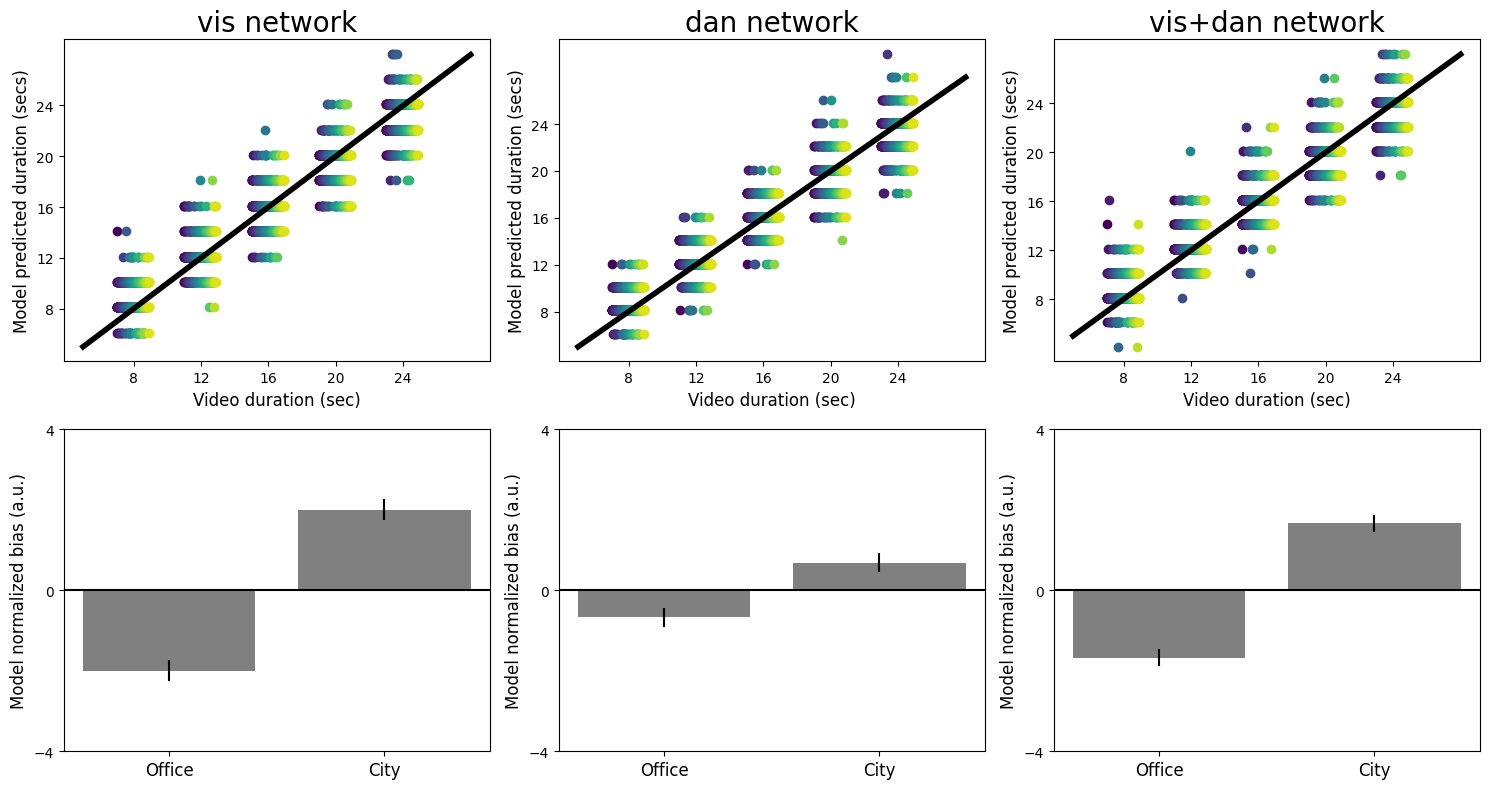

In [ ]:
#plotting FIG6
files = ['vis', 'dan'] #'vis+dan']
durations = [8, 12, 16, 20, 24]
x = np.linspace(5, 28, 5)
y = x  # Função x=y

fig, axs = plt.subplots(2, len(files), figsize=(5 * len(files), 8))
for i, region in enumerate(files):
    load_file = op.join(outdir, 'predicted_{}.csv'.format(region))
    data = pd.read_csv(load_file)
    chart1 = axs[0, i]
    pos = np.linspace(-1, 1, 40)
    for subj in range(1, 41):
        subset = data.loc[(data['subj'] == subj)]
        cor = plt.cm.viridis((subj - 1) / (40 - 1))
        durs = subset['duration']+pos[subj-1]
        chart1.scatter(durs, subset['predicted'], color=cor)
    chart1.set_xlabel('Video duration (sec)', fontsize=12)
    chart1.set_ylabel('Model predicted duration (secs)', fontsize=12)
    chart1.set_xticks(durations)
    chart1.set_yticks(durations)
    #unity
    chart1.plot(x, y, color='black', linewidth=4)
    chart1.set_title(f'{region} network', fontsize=20)

    chart2 = axs[1, i]
    sem_c = np.std(avgmb_c[region]) / np.sqrt(40)
    sem_o = np.std(avgmb_o[region]) / np.sqrt(40)
    x_pos = np.arange(2)
    heights = [np.mean(avgmb_o[region]), np.mean(avgmb_c[region])]
    errors = [sem_o, sem_c]
    chart2.bar(x_pos, heights, yerr=errors, color='grey')
    chart2.set_ylabel('Model normalized bias (a.u.)', fontsize=12)
    chart2.set_xticks(x_pos)
    chart2.set_yticks([-4, 0, 4])
    chart2.set_xticklabels(['Office', 'City'], fontsize=12)
    chart2.axhline(0, color='black')

    plt.tight_layout()

plt.show()

In [ ]:
#plotting FIG6
files = ['fpn', 'aud', 'dan']
durations = [8, 12, 16, 20, 24]
x = np.linspace(5, 28, 5)
y = x  # Função x=y

fig, axs = plt.subplots(2, len(files), figsize=(5 * len(files), 8))
for i, region in enumerate(files):
    load_file = op.join(outdir, 'predicted_{}.csv'.format(region))
    data = pd.read_csv(load_file)
    chart1 = axs[0, i]
    pos = np.linspace(-1, 1, 40)
    for subj in range(1, 41):
        subset = data.loc[(data['subj'] == subj)]
        cor = plt.cm.viridis((subj - 1) / (40 - 1))
        durs = subset['duration']+pos[subj-1]
        chart1.scatter(durs, subset['predicted'], color=cor)
    chart1.set_xlabel('Video duration (sec)', fontsize=12)
    chart1.set_ylabel('Model predicted duration (secs)', fontsize=12)
    chart1.set_xticks(durations)
    chart1.set_yticks(durations)
    #unity
    chart1.plot(x, y, color='black', linewidth=4)
    chart1.set_title(f'{region} network', fontsize=20)

    chart2 = axs[1, i]
    sem_c = np.std(avgmb_c[region]) / np.sqrt(40)
    sem_o = np.std(avgmb_o[region]) / np.sqrt(40)
    x_pos = np.arange(2)
    heights = [np.mean(avgmb_o[region]), np.mean(avgmb_c[region])]
    errors = [sem_o, sem_c]
    chart2.bar(x_pos, heights, yerr=errors, color='grey')
    chart2.set_ylabel('Model normalized bias (a.u.)', fontsize=12)
    chart2.set_xticks(x_pos)
    chart2.set_yticks([-4, 0, 4])
    chart2.set_xticklabels(['Office', 'City'], fontsize=12)
    chart2.axhline(0, color='black')

    plt.tight_layout()

plt.show()

# LSTM


In [1]:
# EACH TRIAL AS A UNIQUE SAMPLE
def standardize(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    standardized_data = (data - mean) / std
    return standardized_data

import warnings
warnings.filterwarnings("ignore")

task = 'bias'
mode = 'ts'
data_type = 'smoothed'
thr = 'nulo'
region = 'rGlasser'
standard=False #standardize ts
print('-------> Loading data for these parameters:')
print(f'TASK = {task}, MODE = {mode}, DATA TYPE = {data_type}, THR = {thr} and REGION = {region}')

if region=='rGlasser':
    n_regions = 360 #glasser atlas
    n_edges = 64620
    triu_idx = np.triu_indices(n_regions ,1)
    region_idx = np.arange(0, 360, 1)
elif region=='visualNet':
    n_regions = 56 #only visual
    n_edges = 1540
    triu_idx = np.triu_indices(n_regions ,1)
    load_file = op.join(datadir, 'ROIs for analysis', 'rGlasser_visual_index.txt')
    region_idx = np.loadtxt(load_file)
    region_idx = [int(value)-1 for value in region_idx]
elif region=='visualSherman':
    n_regions = 3 #only visual
#     n_edges = -
    triu_idx = np.triu_indices(n_regions ,1)
    region_idx = np.arange(0, 3, 1)
elif region=='dan':
    n_regions = 23 #only visual
    n_edges = 253
    triu_idx = np.triu_indices(n_regions ,1)
    load_file = op.join(datadir, 'ROIs for analysis', 'rGlasser_dan_index.txt')
    region_idx = np.loadtxt(load_file)
    region_idx = [int(value)-1 for value in region_idx]
elif region=='cingNet':
    n_regions = 53 #only visual
    n_edges = 1378
    triu_idx = np.triu_indices(n_regions ,1)
    load_file = op.join(datadir, 'ROIs for analysis', 'rGlasser_con_index.txt')
    region_idx = np.loadtxt(load_file)
    region_idx = [int(value)-1 for value in region_idx]
elif region=='dmn':
    n_regions = 77 #only visual
    n_edges = 2926
    triu_idx = np.triu_indices(n_regions ,1)
    load_file = op.join(datadir, 'ROIs for analysis', 'rGlasser_dmn_index.txt')
    region_idx = np.loadtxt(load_file)
    region_idx = [int(value)-1 for value in region_idx]
if region=='rShen':
    n_regions = 268
    n_edges = int((n_regions**2 - n_regions)/2)
    triu_idx = np.triu_indices(n_regions ,1)
    region_idx = np.arange(0, n_regions, 1)
if region=='DL':
    n_regions = 77
    n_edges = int((n_regions**2 - n_regions)/2)
    triu_idx = np.triu_indices(n_regions ,1)
    region_idx = np.arange(0, n_regions, 1)
if region=='ICA':
    n_regions = 99
    n_edges = int((n_regions**2 - n_regions)/2)
    triu_idx = np.triu_indices(n_regions ,1)
    region_idx = np.arange(0, n_regions, 1)

# load data
durations = {8:11, 12:16, 16:21, 20:26, 24:31} #dur:ts_size
videoTypes = [0, 1] #office, city
if task == 'videoType':
    iters = videoTypes
    label = 'isCity'
else:
    iters = durations
    label = 'veridicalDuration'
excluded = [8, 9, 41, 45] # 8 e 9 não existem, 10 tem dados incompletos
load_file = op.join(datadir, 'master_dataset.csv')
df = pd.read_csv(load_file)

ts_data = []
outcome = []
real_dur = []
samples = []
subj_list = []
i=0
for sub in range(4, 46):
    print(sub)
    if sub in excluded:
        print('skipping subject')
        continue
    subj_list.append(sub)
    for run in range(1, 5):
        init = 0 # initialise iteration for ICA-ts extraction
        for j in iters:
            run_data = []
            bias_list = []
            hr_list = []
            for trial in range(1, 21):
                subset = df.loc[(df['rawSubjID'] == sub) & (df['run'] == run) & (df['trial'] == trial)] # & (df['isCity'] == 1)]
                if len(subset)!=0:
                    hr = float(subset['humanReport'].values)
                    vt = int(subset['isCity'].values)
                    hb = float(subset['humanBias'].values)
                    dur = int(subset['veridicalDuration'].values)
                    acc = float(subset['estimationAcc'].values)
                    gender = int(subset['gender'].values)-1
                    if thr!='nulo':
                        if hr<((1-thr)*j) or hr>((1+thr)*j):
                            print('Skipping trial due to large estimation error')
                            continue

                    if hr.is_integer():
                        hr = int(hr)
                    else:
                        pass

                    if mode=='ts' or mode=='diff':
                        tsdir = op.join(datadir, 'extracted_voxels', str(sub), 'time_series')
                        tsMatFile = op.join(tsdir, 'rGlasserTS_run'+str(run)+'_trial'+str(trial)+'_dur='+str(hr)+'.mat')
                        if data_type=='smoothed':
                            tsdir = op.join(datadir, 'extracted_voxels', str(sub), 'time_series', 'smoothed')
                            tsMatFile = op.join(tsdir, 'rGlasserTS_run'+str(run)+'_trial'+str(trial)+'_dur='+str(hr)+'.mat')
                            if region=='rShen':
                                tsMatFile = op.join(tsdir, 'rShenTS_run'+str(run)+'_trial'+str(trial)+'_dur='+str(hr)+'.mat')
                        if data_type=='dubois_pipeline':
                            tsdir = op.join(datadir, 'extracted_voxels', str(sub), 'time_series', 'dubois_pipeline')
                            tsMatFile = op.join(tsdir, 'rGlasserTS_run'+str(run)+'_trial'+str(trial)+'_dur='+str(hr)+'.mat')

                    if mode=='random_corr':
                        tsdir = r'C:\Users\erick\Documents\mestrado\extracted_voxels'
                        tsMatFile = op.join(tsdir, str(sub), 'whole_TS', 'rGlasserTS_run'+str(run)+'.mat')
                        if data_type=='smoothed':
                            tsdir = op.join(tsdir, str(sub), 'whole_TS', 'smoothed')
                            tsMatFile = op.join(tsdir, 'rGlasserTS_run'+str(run)+'.mat')

                    if region=='ICA':
                        tsdir = r'C:\Users\erick\Documents\mestrado\subjects\task_volumes\ica_ts'
                        tsMatFile = op.join(tsdir, 'subject_{}_run_{}_4D.mat'.format(sub, run))
                    if region=='DL':
                        tsdir = r'C:\Users\erick\Documents\mestrado\subjects\task_volumes\DL_ts'
                        tsMatFile = op.join(tsdir, 'subject_{}_run_{}_4D.mat'.format(sub, run))
                    if region=='visualSherman':
                        tsdir = op.join(datadir, 'extracted_voxels', str(sub), 'time_series', 'smoothed')
                        tsMatFile = op.join(tsdir, 'visualSherman_TS_run'+str(run)+'_trial'+str(trial)+'_dur='+str(hr)+'.mat')
                        regions = ['rLOC', 'rVO', 'rV1']
                        if not op.isfile(tsMatFile):
                            fdata = []
                            for reg in regions:
                                rFile = op.join(tsdir, reg+'_TS_run'+str(run)+'_trial'+str(trial)+'_dur='+str(hr)+'.mat')
                                rdata = sio.loadmat(rFile)
                                rdata = rdata['avg_data']
                                fdata.append(rdata)

                            fdata = np.array(fdata).reshape(3, -1)
                            dataDic = {'avg_data': fdata}
                            sio.savemat(tsMatFile, dataDic)

                    if op.isfile(tsMatFile) and subset[label].values==j:
                        print(tsMatFile)
                        print(f'Subj {sub}, amostra {i}, run {run}, {label} = {j}')
                        data = sio.loadmat(tsMatFile)
                        fdata = data['avg_data'][region_idx]
#                         if region=='ICA':
#                             fdata = data['avg_data'].reshape(n_regions, -1)[region_idx]
#                             current_size = iters[j]
#                             fdata = fdata[:, init:init+current_size]
# #                             print(fdata.shape)
#                             init = init + current_size
#                         if mode=='random':
#                             init_idx = np.random.randint(10, fdata.shape[1]-50)
#                             final_idx = init_idx+iters[j]
#                             fdata = fdata[:, init_idx:final_idx]
#                         if mode == 'diff':
#                             fdata = np.diff(data['avg_data'][region_idx])

                        nans = np.sum(np.isnan(fdata))
                        if nans!=0:
                            print('NANS', nans)
                        else:
                            run_data.append(fdata)
                            samples.append([i, str(sub), run, dur, vt, hb])
                            i=i+1

                        del data

                        if task=='bias':
                            outcome.append(hb)
                        if task=='verDur':
                            outcome.append(hr)
                            real_dur.append(j)
                        if task=='realDur':
                            outcome.append(j)
                        if task=='repError':
                            outcome.append(np.mean(error_list))
                        if task=='videoType':
                            outcome.append(vt)
#                             print(outcome)
                        if task=='repAcc':
                            outcome.append(acc)
                        if task=='gender':
                            outcome.append(gender)

            if len(run_data)!=0:
#                 print(f'Subj {sub}, amostra {i}, run {run}')
                ts_data += run_data
            else:
                print(f'Inexistent data for subj {sub}, run = {run}')

if standard:
    ts_data = [standardize(data) for data in ts_data]
ts_data = [torch.tensor(ts, dtype=torch.float32) for ts in ts_data]

if task=='durClass':
    outcome = [int((value - 8)/4) for value in outcome]
#     outcome = F.one_hot(torch.tensor(outcome), num_classes=5)
elif task=='videoType':
    samples = pd.DataFrame(samples, columns=['sample', 'subj', 'run', 'dur', 'isCity', 'humanBias'])
elif task=='gender':
    samples = pd.DataFrame(samples, columns=['sample', 'subj', 'run', 'dur', 'isCity', 'humanBias'])
#     samples = samples.sort_values(by=['dur', 'sample'])
elif task=='bias' or task=='repAcc':
    outcome = standardize(outcome)
    samples = pd.DataFrame(samples, columns=['sample', 'subj', 'run', 'dur', 'isCity', 'humanBias'])
#     samples = samples.sort_values(by=['dur', 'sample'])
else:
    outcome = np.log(outcome)
#     outcome = standardize(outcome)
    samples = pd.DataFrame(samples, columns=['sample', 'subj', 'run', 'dur', 'isCity', 'humanBias'])
    samples = samples.sort_values(by=['dur', 'sample'])

## final shape: [trials, region, ts]

In [53]:
#LSTM
seed = 1029
np.random.seed(seed)
torch.manual_seed(seed)

#LSTM parameters
input_size = n_regions
hidden_size = 32
num_layers = 2
bidir = False
if bidir:
    multip = 2
else:
    multip = 1

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
    if hasattr(layer, 'reset_parameters'):
        print(f'Reset trainable parameters of layer = {layer}')
        layer.reset_parameters()

class BiLSTM(nn.Module):
    def __init__(self, num_layers, hidden_size, num_classes, input_size, dropout):
        super(BiLSTM, self).__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, bias=True, batch_first=True, bidirectional=bidir)
        self.fc = nn.Linear(hidden_size * multip, num_classes)
        self.exp = nn.Softplus()
        self.softmax = nn.Softmax(-1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs, lengths, task):
        h0 = torch.zeros(self.num_layers * multip, inputs.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * multip, inputs.size(0), self.hidden_size).to(device)

        # Package the sequence
        packed_inputs = nn.utils.rnn.pack_padded_sequence(inputs, lengths, batch_first=True, enforce_sorted=False)

        # Forward propagate LSTM
        packed_output, (hn, cn) = self.lstm(packed_inputs, (h0, c0))
        lstm_output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        print('LTSM out shape:', lstm_output.shape) # [batch size, ts length, hidden_size]

        lstm_output = torch.mean(lstm_output, 1)
#         lstm_output = lstm_output.reshape(-1, hidden_size, lstm_output.shape[1])
        output = self.fc(lstm_output)
        print('fully-conn out shape:', output.shape)
#         output = torch.mean(output, 1)
        print('final out shape:', output.shape)

        if task=='videoType' or task=='durClass' or task=='gender':
            output = self.softmax(output)
#         else:
#             output = self.exp(output)

        return output

# net = MultiScaleConv1d_LSTM(
#                 in_channels, out_channels, kernel_sizes, num_layers, hidden_size, num_classes, input_size).to(device)

# optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) #weight_decay=0.0005)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

print('defining the net and dataset')

defining the net and dataset


In [54]:
#LSTM WITH ATTENTION
seed = 1029
np.random.seed(seed)
torch.manual_seed(seed)

#LSTM parameters
input_size = n_regions
hidden_size = 32
num_layers = 2
bidir = False
if bidir:
    multip = 2
else:
    multip = 1

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
    if hasattr(layer, 'reset_parameters'):
        print(f'Reset trainable parameters of layer = {layer}')
        layer.reset_parameters()

class BiLSTMWithAttention(nn.Module):
    def __init__(self, num_layers, hidden_size, num_classes, input_size, dropout):
        super(BiLSTMWithAttention, self).__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, bias=True, batch_first=True, bidirectional=bidir)
        self.attention = nn.MultiheadAttention(hidden_size, num_heads=8, batch_first=True)
        self.fc = nn.Linear(hidden_size * multip, num_classes)
        self.exp = nn.Softplus()
        self.softmax = nn.Softmax(-1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs, lengths, task):
        h0 = torch.zeros(self.num_layers * multip, inputs.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * multip, inputs.size(0), self.hidden_size).to(device)

        # Package the sequence
        packed_inputs = nn.utils.rnn.pack_padded_sequence(inputs, lengths, batch_first=True, enforce_sorted=False)

        # Forward propagate LSTM
        packed_output, (hn, cn) = self.lstm(packed_inputs, (h0, c0))
        lstm_output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        print('LTSM out shape:', lstm_output.shape) # [batch size, ts length, hidden_size]

        # Apply attention
        attention_output = self.attention(lstm_output, lstm_output, lstm_output)[0]
        attention_output += lstm_output
        print('attention out shape:', attention_output.shape)

        # Fully connected layer
        output = self.fc(attention_output)
        output = torch.mean(output, 1)
        print('final out shape:', output.shape)

        if task=='videoType' or task=='durClass' or task=='gender':
            output = self.softmax(output)
#         else:
#             output = self.exp(output)

        return output

print('defining the net and dataset')

defining the net and dataset


In [56]:
from pytorch_tcn import TCN
class TCNWithFC(nn.Module):
    def __init__(self, seq_len):
        super(TCNWithFC, self).__init__()
        self.tcn = TCN(
                num_inputs=seq_len,
                num_channels=[64, 32, 16, 8, 4, 2, 1],
                kernel_size=2,
                dilations = None, # Optional[ ArrayLike ]
#                 dilaton_reset = None, # Optional[ int ]
                dropout = 0,
                causal=True,
                use_norm=None,
                activation='relu',
                kernel_initializer='xavier_uniform',
                use_skip_connections = False,
                input_shape = 'NLC',
            )
        self.fc = nn.Linear(31, 1)

    def forward(self, x):
        # O pytorch-tcn usa entrada no formato NLC, então a saída será [batch_size, seq_len, num_channels[-1]]
        y = self.tcn(x)
        y = torch.mean(y, axis=2)
        y = y.reshape(-1, y.shape[1])
        print('tcn shape:', y.shape)
#         y = y[:, -1, :]  # Pegando a última saída da sequência
        y = self.fc(y)   # Passando pela camada fully connected
        return y

In [57]:
#VIDEO DURATION
def runPrediction(ts_data, samples, subj_list, target, outcome, model, outDir, k_folds, num_epochs, batch_size,
                  dropout, learning_rate, step_size, gamma, num_classes, criterion, reload_model, overwrite, confounds):

    if not op.isdir(outDir):
        os.mkdir(outDir)

    # Create plot directory
    plotDir = op.join(outDir, 'Figures')
    if not op.isdir(plotDir):
        os.mkdir(plotDir)

    n_samples       = len(ts_data)
    seq_len      = ts_data[0].shape[0]
#     timepoints      = ts_data.shape[2]
    ground_truth = np.array(outcome)

    class MyDataset(Dataset):
        def __init__(self):
            # Initialize data, download, etc.
            self.n_samples = n_samples

            # here the first column is the class label, the rest are the features
            self.x_data = ts_data
            self.y_data = ground_truth

        # support indexing such that dataset[i] can be used to get i-th sample
        def __getitem__(self, index):
            ts = self.x_data[index]
            length = ts.size(1)
            return self.x_data[index], self.y_data[index], length

        # we can call len(dataset) to return the size
        def __len__(self):
            return self.n_samples

    def collate_fn(batch):
        # Ordena o batch pela duração das sequências em ordem decrescente
        batch.sort(key=lambda x: x[2], reverse=True)
        sequences, labels, lengths = zip(*batch)
        sequences = [seq.reshape(seq.size(1), seq.size(0)) for seq in sequences]

        # Preenche as sequências para o mesmo comprimento
        sequences_padded = nn.utils.rnn.pad_sequence(sequences, batch_first=True)

        labels = torch.tensor(labels)
        lengths = torch.tensor(lengths)

        return sequences_padded, labels, lengths

    # create dataset
    dataset = MyDataset()
    print("=========================")

    # Define the K-fold Cross Validator
    targ = samples.loc[:, 'subj']
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=1029)
    cv = skf.split(samples, targ)

    # K-fold Cross Validation model evaluation
    for fold, subj in enumerate(subj_list):
        train_val_ids = np.ravel(samples.loc[~(samples['subj'] == str(subj)), 'sample'])
        train_val_ids = list(train_val_ids)
        test_ids = np.ravel(samples.loc[(samples['subj'] == str(subj)), 'sample'])

        # selecting homogenous val ids
        val_ids = []
        val_size = 30
        window = int(len(train_val_ids)/5)
        j = 0
        for i in range(0, 5):
            subset = list(train_val_ids[j: j+window])
            val_ids.append(np.random.choice(subset, int(val_size/5), replace=False))
            j += window
        val_ids = np.concatenate(val_ids, axis=0)
        val_ids = list(val_ids)
        print(f'Val_ids: {val_ids}')

        train_ids = train_val_ids
        for i in val_ids:
            train_ids.remove(i)
        print(f'Test_ids: {test_ids} ')
        print(f'Training fold {fold}, includes all subjects but {subj}')
        test = samples.loc[test_ids,:]
        print(test_ids)

        outFile = op.join(outDir,'{}.mat'.format(
           'Fold_' + str(fold)))
        print(outFile)

        if op.isfile(outFile) and not overwrite:
            continue

        if reload_model:
            test_ids = np.squeeze(test_list[fold])
            print(test_ids)

        # Print
        print('FOLD {}'.format(fold))
        print('--------------------------------')
        if model=='BiLSTM':
            net = BiLSTM(num_layers, hidden_size, num_classes, input_size, dropout).to(device)
        elif model=='BiLSTMWithAttention':
            net = BiLSTMWithAttention(num_layers, hidden_size, num_classes, input_size, dropout).to(device)
        elif model=='TCN':
            net = TCNWithFC(seq_len).to(device)
        net.apply(reset_weights)
        print('--------------------------------')
        print(net)
        print('--------------------------------')

        # Run the training loop for defined number of epochs
        print(f'Parameters: LR = {learning_rate}, Step size = {step_size}, gamma = {gamma}' )
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
        loss_list = []
        val_list = []

        # Early stopping
        last_loss = 1
        patience = 3
        trigger_times = 0

        for epoch in range(1, num_epochs+1):

            # Sample elements sequentially from a given list of ids, no replacement.
            train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
            test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
            val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

            # Define data loaders for training and testing data in this fold
            train_loader = torch.utils.data.DataLoader(
                          dataset,
                          batch_size=batch_size, sampler=train_subsampler, collate_fn=collate_fn)
            test_loader = torch.utils.data.DataLoader(
                          dataset,
                          batch_size=100, sampler=test_subsampler, collate_fn=collate_fn)
            val_loader = torch.utils.data.DataLoader(
                          dataset,
                          batch_size=batch_size, sampler=val_subsampler, collate_fn=collate_fn)

            outModel = op.join(outDir, f'model_fold{fold}.pth')
            print(outModel)
            if op.isfile(outModel) and reload_model:
                print(f'Reloading model')
                print(f'Test_ids: {test_ids}')
                net.load_state_dict(torch.load(outModel))
                break

            # Print epoch
            print('Starting epoch {}'.format(epoch))

            # TRAIN
            net.train()
            start_time     = time()

            avg_loss = []
            for i, (ts, outcome, lengths) in enumerate(train_loader):
                # origin shape: [N, n_regions, timepoints]
#                     ts = ts.reshape(-1, ts.shape[2], seq_len).to(device)
                print('ts shape', ts.shape)
                if target=='videoType' or target=='durClass' or target=='gender':
                    outcome = torch.tensor(outcome, dtype=torch.long).to(device)
                else:
                    outcome = torch.tensor(outcome, dtype=torch.float32).to(device)

                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass
                if model=='TCN':
                    outputs = net(ts).to(device)
                else:
                    outputs = net(ts, lengths, target).to(device)
                print('INPUT LENGTHS:', lengths)
                print(f'output shape is {outputs.shape} and label shape is {outcome.shape}')
                loss = criterion(outputs, outcome)

                # Backward and optimize
                loss.backward()
                optimizer.step()

                # Print statistics
                avg_loss.append(loss.item())
                print('Loss after mini-batch %5d: %.3f' %
                          (i, loss.item()))

            elapsed_time = time() - start_time
            scheduler.step()
            avg_loss = statistics.mean(avg_loss)
            loss_list.append(avg_loss)

            #validation
            net.eval()
            val_out_list = []
            out_list = []
            avg_loss = []
            with torch.no_grad():
                for i, (ts, outcome, lengths) in enumerate(val_loader):
#                         ts = ts.reshape(-1, ts.shape[2], seq_len).to(device)
                    if target=='videoType' or target=='durClass' or target=='gender':
                        outcome = torch.tensor(outcome, dtype=torch.long).to(device)
                    else:
                        outcome = torch.tensor(outcome, dtype=torch.float32).to(device)

                    correct, total = 0, 0

                    if model=='TCN':
                        val_out = net(ts).to(device)
                    else:
                        val_out = net(ts, lengths, target).to(device)
                    val_out_list.append(val_out)
                    print(outcome)
                    out_list.append(outcome)
                    print(val_out)
                    val_loss = criterion(val_out, outcome)
                    print('Val_Loss after epoch %5d and batch %5d: %.3f' %
                          (epoch, i, val_loss))
                    avg_loss.append(val_loss.item())

                avg_loss = statistics.mean(avg_loss)
                val_list.append(avg_loss)

#                 # Early stopping
#                 current_loss = val_loss
#                 if current_loss > last_loss:
#                     trigger_times += 1
#                     print('Trigger Times:', trigger_times)

#                     if trigger_times >= patience:
#                         print('Early stopping!\nStart to test process.')
#                         break
#                 else:
#                     print('trigger times: 0')
#                     trigger_times = 0
#                 last_loss = current_loss

                # Print accuracy
                if target=='videoType' or target=='durClass'or target=='gender':
                    _, predicted = torch.max(val_out.data, 1)
                    total += len(outcome)
                    print(predicted)
                    correct += (predicted == outcome).sum().item()
                    print('Accuracy for epoch %d: %d %%' % (epoch, 100.0 * correct / total))
                    print('--------------------------------')
                else:
                    outcome = np.asarray(torch.Tensor.cpu(torch.concatenate(out_list, axis=0)))

                    val_out = np.squeeze(np.asarray(torch.Tensor.cpu(torch.concatenate(val_out_list, axis=0))))
#                         print(len(val_out), len)
                    print(f'out shape: {val_out.shape}, label shape: {outcome.shape}')
                    rho,p   = stats.pearsonr(np.ravel(val_out), np.ravel(outcome))
                    print('Performance for epoch {} is: r = {}, p = {}'.format(epoch, rho, p))
                    print('--------------------------------')

            print("Trained model in {0:02d}h:{1:02d}min:{2:02d}s".format(int(elapsed_time//3600),
                                                                             int((elapsed_time%3600)//60),int(elapsed_time%60)))

        # Process is complete.
        print('Training process has finished. Saving trained model.')

        # Print about testing
        print('Starting testing')

        # Saving the model and loss
        if not reload_model:
            save_path = op.join(outDir,'model_fold{}.pth'.format(fold))
            torch.save(net.state_dict(), save_path)

        loss_path = op.join(outDir,'loss_fold{}.csv'.format(fold))
        loss_list = np.array(loss_list).reshape(len(loss_list), 1)
        val_loss = np.array(val_list).reshape(len(val_list), 1)
        total_loss = pd.DataFrame(np.concatenate((loss_list, val_loss), axis=1), columns=['Train Loss', 'Val Loss'])
        total_loss.to_csv(loss_path, sep=',', encoding='utf-8')

        #Plot curve
        get_ipython().run_line_magic('matplotlib', 'inline')
        epochs = np.arange(1, len(loss_list)+1, 1)
        plt.title(f'Loss Curve: Fold {fold}')
        plt.plot(epochs, loss_list, label='Train loss')
        plt.plot(epochs, val_loss, label='Val Loss')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Cost function')
        plt.show()
        plt.savefig(op.join(plotDir, 'Training_curves_Fold_{}.png'.format(fold)), format='png')


        # PREDICT
        pred_list = []
        out_list = []
        net.eval()
        with torch.no_grad():
            for (ts, outcome, lengths) in test_loader:
#                     ts = ts.reshape(-1, ts.shape[2], seq_len).to(device)
                if target=='videoType' or target=='durClass'or target=='gender':
                    outcome = torch.tensor(outcome, dtype=torch.long).to(device)
                else:
                    outcome = torch.tensor(outcome, dtype=torch.float32).to(device)
                print('INPUT LENGTHS:', lengths)

                if model=='TCN':
                    pred = net(ts).to(device)
                else:
                    pred  =  net(ts, lengths, target).to(device)
                pred_list.append(pred)
                out_list.append(outcome)

        print(pred_list)
        pred = torch.concatenate(pred_list)
        outcome = torch.concatenate(out_list)
        test_loss = criterion(pred, outcome)
        print(f'Test_Loss is:  {test_loss.item()}')

        # Print accuracy
        correct, total = 0, 0
        if target=='videoType' or target=='durClass'or target=='gender':
            probs = np.asarray(torch.Tensor.cpu(pred))
            outcome = np.asarray(torch.Tensor.cpu(outcome))
            print('OUTPUT FOR THIS FOLD:', pred)
            print('OUTCOME FOR THIS FOLD:', outcome)
            print('Predicted probs:', probs.shape)
            _, pred = torch.max(pred.data, 1)
            pred = np.asarray(torch.Tensor.cpu(pred))
            total += len(outcome)
            correct += (pred == outcome).sum().item()
            print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
            print('--------------------------------')
        else:
            pred = np.asarray(pred_list)
            print(f'Test pred is: {pred}')
            outcome = np.asarray(out_list)
            rho,p   = stats.pearsonr(np.ravel(pred), np.ravel(outcome))
            print('Performance for fold {} is: r = {}, p = {}'.format(fold, rho, p))
            probs = 'não se aplica'
            print('--------------------------------')

        results        = {
                    'test_index':test_ids,
                    'score':np.asarray(outcome).flatten(),
                    'pred':np.asarray(pred).flatten(),
                    'probs':probs,
                    'complete epochs': epoch, 'lr': learning_rate, 'step-size': step_size, 'gamma': gamma
                    }
        
        sio.savemat(outFile, results)

    return dataset

> BiLSTM
--------> bias
-------------------------------------
D:\ERICK\MD\prediction_data\BiLSTM\visualSherman\bias\bias_BiLSTM_lr=0.0005_ss=1_g=0.1_seed=1029_LOSO_noDecon_bidir=False_standard=False_mode=ts_SMOOTHED_padded_TRIAL-BY-TRIAL
rho=0.000 +/- 0.00003 and R2=-0.003 +/- 0.00509
Final performance is: r = 0.020144641594591766, p = 0.34374728831763507, R2 = -0.0019463432122581725
-------------------------------------
D:\ERICK\MD\prediction_data\BiLSTM\visualSherman\bias\bias_BiLSTM_lr=0.0005_ss=1_g=0.5_seed=1029_LOSO_noDecon_bidir=False_standard=False_mode=ts_SMOOTHED_padded_TRIAL-BY-TRIAL
rho=0.000 +/- 0.00007 and R2=-0.002 +/- 0.00229
Final performance is: r = 0.028277129286472098, p = 0.1838016403541899, R2 = -0.001148318076731103
-------------------------------------
D:\ERICK\MD\prediction_data\BiLSTM\visualSherman\bias\bias_BiLSTM_lr=0.0005_ss=2_g=0.1_seed=1029_LOSO_noDecon_bidir=False_standard=False_mode=ts_SMOOTHED_padded_TRIAL-BY-TRIAL
rho=0.000 +/- 0.00000 and R2=-0.001 +/

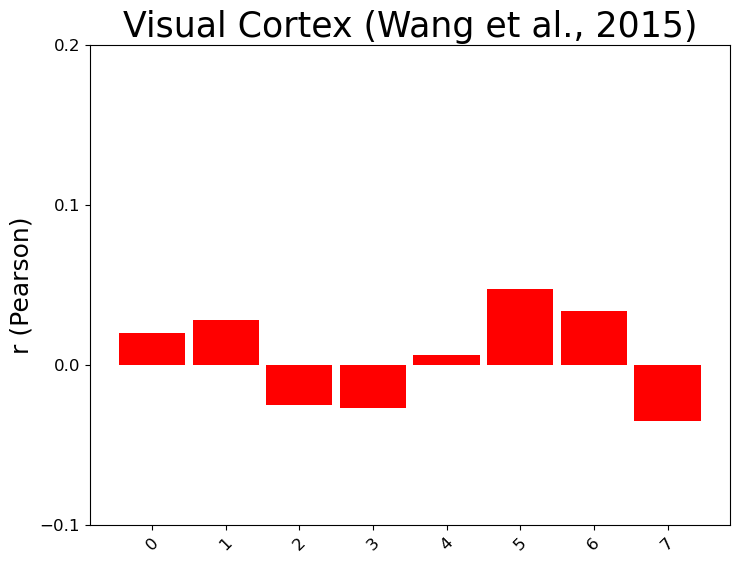

In [66]:
#----------------------
# predict!
#----------------------
import scipy.stats as stats

overwrite = False
overwrite_res = False
reload_model = False
continuing = False
# grid_search = True
decon = 'noDecon'
model_class='BiLSTM'

task = 'bias'
region = 'visualSherman'
standard = False
data_type = 'smoothed'
bidir = False

Task = [task]

# Hyper-parameters
num_epochs = 30
dropout = 0.5
k_folds = len(subj_list)

# otimization
learning_rate = [0.0005, 0.0001]
step_size = [1, 2]
gamma = [0.1, 0.5]

# param_grid = {
#     'hidden_size': [16, 32, 64, 128],
#     'learning_rate': [0.0005, 0.0001, 0.001],
#     'step_size': [1, 2],
#     'gamma': [0.1, 0.5],
#     'num_layers': [2, 4, 6, 8]
# }

# # best parameters
# learning_rate = [0.0005]
# step_size = [2]
# gamma = [0.5]

#seed
seed = 1029
np.random.seed(seed)
torch.manual_seed(seed)

# print ('nsub{}, {}, {}'.format(ts_data.shape[0], session, fctype))
for model in [model_class]:
    print ('> {}'.format(model))
    for target in Task:
        # Loss and optimizer
        if target == 'verDur' or target == 'realDur' or target == 'bias' or task=='repAcc':
            num_classes = 1
#             k_folds = 10
            batch_size = 180
            criterion = nn.MSELoss()
        if target == 'videoType':
            num_classes = 2
#             k_folds = 5
            batch_size = 64
            criterion = nn.CrossEntropyLoss()
        if target == 'durClass':
            num_classes = 5
#             k_folds = 10
            batch_size = 64
            criterion = nn.CrossEntropyLoss()
        if task == 'gender':
            num_classes = 2
#             k_folds = 10
            batch_size = 64
            criterion = nn.CrossEntropyLoss()
        print ('--------> '+ target)
        perf = []
        error = []
        labels = []
        colors = []
        for i, lr in enumerate(learning_rate):
            for j, ss in enumerate(step_size):
                for h, g in enumerate(gamma):
                    labels.append(str(i)+str(j)+str(h))
                    thisOutDir = op.join(outdir, 'BiLSTM', region, target,
                                         '{}_{}_lr={}_ss={}_g={}_seed={}_LOSO_{}_bidir={}_standard={}_mode={}'
                                         .format(target, model, lr, ss, g, seed, decon, bidir, standard, mode)) #tirar 'bidir' se for videoType
                    if data_type=='smoothed':
                        thisOutDir = op.join(outdir, model, region, target,
                                         '{}_{}_lr={}_ss={}_g={}_seed={}_LOSO_{}_bidir={}_standard={}_mode={}_SMOOTHED_padded_TRIAL-BY-TRIAL'
                                         .format(target, model, lr, ss, g, seed, decon, bidir, standard, mode))
                    if decon == 'noDecon':
                        confounds=[]

                    #run prediction
                    if overwrite or not op.isdir(thisOutDir) or continuing:
                        clear_output()
                        print(thisOutDir)
                        runPrediction(ts_data, samples, subj_list, target=target, outcome=outcome, model=model, outDir=thisOutDir, k_folds=k_folds,
                                      num_epochs=num_epochs, batch_size=batch_size, dropout=dropout, learning_rate=lr, step_size=ss, gamma=g,
                                      num_classes=num_classes, criterion=criterion, reload_model=reload_model, overwrite=overwrite, confounds=confounds)

                   # merge cross-validation folds, save results
                    print('-------------------------------------')
                    print(thisOutDir)
                    resFile     = op.join(thisOutDir,'result.mat')

                    if (not op.isfile(resFile)) or overwrite_res:
                        obs                = np.zeros([len(ts_data), 1])
                        predictions_pos = np.zeros([len(ts_data), 1])
                        probs_pos    = np.zeros([len(ts_data), 1])
                        corr_list = []
                        r2_list = []
                        acc_list = []
                        auc_list = []
                        false_list = []
                        for fold in range(k_folds):
                            cvResFile = op.join(thisOutDir, '{}.mat'.format(
                                'Fold_' + str(fold)))
                            results = sio.loadmat(cvResFile)
                            test_ids = np.squeeze(results['test_index'])
                            print(test_ids)
                            mascara = samples['sample'].isin(test_ids)
                            subset = samples[mascara].to_string(index=False)
                            print('-------------------------------')
                            print('Final results for fold', fold)
                            if target=='videoType' or target=='durClass'or target=='gender':
                                score = np.squeeze(results['score'])
                                probs = np.squeeze(results['probs'][:, 1])
                                pred = np.squeeze(results['pred'])
#                                 false_positive_rate, true_positive_rate, threshold = roc_curve(score, probs)
#                                 auc = roc_auc_score(np.squeeze(results['score']), np.squeeze(results['probs'][:, 1]))
#                                 print(f'AUC score for fold {fold}: {auc}')
                                total = len(score)
                                correct = (pred == score).sum().item()
                                acc = 100.0 * correct / total
                                acc_list.append(acc)
#                                 auc = roc_auc_score(score, probs)
#                                 auc_list.append(auc)
                                print('Accuracy:' , acc)

                                true = pred == score
                                false = np.count_nonzero(pred != score)
                                print(false)
                                false_list.append(false)
                                combined_array = np.column_stack((true, np.squeeze(results['test_index'])))
        
                            else:
                                rho, p   = stats.pearsonr(np.ravel(results['pred']), np.ravel(results['score']))
                                pred, score = np.ravel(results['pred']), np.ravel(results['score'])
                                R2 = 1 - np.sum(np.square(score-pred)) / np.sum(np.square(score-np.mean(score)))
                                print(f'Peformance for fold {fold}: r = {rho}, p = {p}')
                                corr_list.append(rho)
                                r2_list.append(R2)

#                                 # final distribuition
#                                 fig = plt.figure()
#                                 ax = fig.add_axes([0,0,1,1])
#                                 ax.scatter(pred, score, color='blue', label='Subject')
#         #                         ax.set_yticks(np.arange(-3, 4, 1))
#                                 ax.set_xticks(np.arange(-3, 4, 1))
#                                 ax.set_ylabel('Observações')
#                                 ax.set_xlabel('Predições')
#                                 # plt.plot(y_test, y_pred, color='blue', linewidth=3, label='Elastic-Net')
#                                 plt.legend()
#                                 plt.show()

                            for test_index in results['test_index']:
                                if target=='videoType' or target=='durClass'or target=='gender':
                                    probs_pos[test_index]          = results['probs'][:, 1].reshape(len(results['probs']), 1)
                                predictions_pos[test_index]    = results['pred'].T
                                obs[test_index]                = results['score'].T

#                             dataFile = op.join(thisOutDir,'loss_fold{}.csv'.format(fold))
#                             if op.isfile(dataFile):
#                                 loss = pd.read_csv(dataFile)
#                                 %matplotlib inline
#                                 epochs = np.arange(1, len(loss)+1, 1)
#                                 plt.title(f'Loss Curve: Fold {fold}')
#                                 plt.plot(epochs, loss['Train Loss'], label='Train Loss')
#                                 plt.plot(epochs, loss['Val Loss'], label='Validation Loss')
#                                 plt.legend()
#                                 plt.xlabel('Epoch')
#                                 plt.ylabel('Criterion')
#                                 plt.show()

                        if target=='videoType' or target=='durClass' or target=='gender':
                            total = len(obs)
                            correct = (predictions_pos == obs).sum().item()
                            acc = (100.0 * correct / total)
                            auc = roc_auc_score(obs, probs_pos)
                            print('Final accuracy:' , acc)

                            #ROC curve
#                             plt.figure()
#                             false_positive_rate, true_positive_rate, threshold = roc_curve(obs, probs_pos)
#                             auc = roc_auc_score(obs, probs_pos)
#                             print(f'Final AUC score: {auc}')

            #                 RocCurveDisplay.from_predictions(obs, probs_pos)

            #                 plt.title(f'ROC Curve - {session}')
            #                 plt.plot([0, 1], ls="--")
            #                 plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
            #                 plt.ylabel('True Positive Rate')
            #                 plt.xlabel('False Positive Rate')
            #                 plt.show()
            #                 plt.savefig(op.join(thisOutDir, 'Figures', "ROC_{}.jpeg".format(session)), format='jpeg')

                            results = {'obs':obs,
                                       'pred':predictions_pos, 'auc':auc, 'acc':acc}
#                                       'fold-std': np.std(auc_list)}

                        else:
                            rho,p   = stats.pearsonr(np.ravel(predictions_pos),np.ravel(obs))
                            results = {'obs':obs,
                                       'pred':predictions_pos,
                                       'rho':rho, 'p': p,
                                       'fold-avg-rho':np.mean(corr_list), 'fold-std':np.std(corr_list),
                                       'fold-avg-R2':np.mean(r2_list), 'R2-std':np.std(r2_list)}
#                             print(f'Mean rho is: {np.mean(corr_list)} +/- {np.std(corr_list)}')
#                             print(f'Mean R2 is: {np.mean(r2_list)} +/- {np.std(r2_list)}')

#                             # PLOT OBSERVED vs. PREDICTED
#                             g  = sns.jointplot((np.ravel(predictions_pos), np.ravel(obs)))
#                             # adjust the axes
#                             lims = [-3,3]
#                             g.ax_joint.set_xlim(lims)
# #                             g.ax_joint.set_ylim(lims)
#                             g.ax_joint.set_xlabel('predicted')
#                             g.ax_joint.set_ylabel('observed')
#                             # PLOT THE 1:1 line
#                             line = plt.Line2D(lims,lims, c='k', linestyle='--')
#                             g.ax_joint.add_line(line)
#                             # FIT REGRESSION LINE
#                             regr = linear_model.LinearRegression()
#                             regr.fit(predictions_pos.reshape(-1,1), obs.reshape(-1,1))
#                             line = plt.Line2D(np.array(lims).reshape(-1,1),regr.predict(np.array(lims).reshape(-1,1)), c='b', linestyle='-')
#                             g.ax_joint.add_line(line)

                        # save result
                        sio.savemat(resFile, results)

                    results = sio.loadmat(resFile)
                    if target=='videoType' or target=='durClass'or target=='gender':
                        auc = results['auc'][0][0]
                        acc = results['acc'][0][0]
                        print('auc={:.3f} and acc={:.3f}'.format(auc, acc)
                              )
                        perf.append(results['acc'][0][0])
#                         error.append(results['fold-std'][0][0])
                        ylabel = 'Accuracy (%)'
                        colors = ['r']*(len(perf))

                    else:
                        print ('rho={0:.3f} +/- {1:.5f} and R2={2:.3f} +/- {3:.5f}'.format(
                            results['fold-avg-rho'][0][0], results['fold-std'][0][0],
                            results['fold-avg-R2'][0][0], results['R2-std'][0][0])
                              )
#                         perf.append(results['fold-avg-rho'][0][0])
#                         error.append(results['fold-std'][0][0])
                        ylabel = 'r (Pearson)'

                        preds = np.exp(np.ravel(results['pred']))
                        obs = np.exp(np.ravel(results['obs']))
                        rho,p   = stats.pearsonr(preds, obs)
                        R2 = 1 - np.sum(np.square(results['obs']-results['pred'])) / np.sum(np.square(results['obs']-np.mean(results['obs'])))
                        modelo = sm.OLS(results['obs'], sm.add_constant(results['pred'])).fit()
                        perf.append(rho)
                        if p < 0.005 and rho>0:
                            colors.append('b')
                        else:
                            colors.append('r')
                        print('Final performance is: r = {}, p = {}, R2 = {}'.format(rho, p, R2))

                        if modelo.f_pvalue < 0.005 and rho>0:
                            print('------> Linear Regression between observed and model {}: beta = {:.2f} ± {:.2f}, p = {:.3f}'
                                  .format(task, modelo.params[1], modelo.bse[1], modelo.f_pvalue))
                            # final distribuition
                            fig = plt.figure()
                            ax = fig.add_axes([0,0,1,1])
                            ax.scatter(results['pred'], results['obs'], color='blue', label='Subject')
                            plt.plot(results['pred'], modelo.params[1] * results['pred'] + modelo.params[0], color='red', linewidth=2, label='Regressão Linear')
    #                         ax.set_yticks(np.arange(-3, 4, 1))
                            ax.set_xticks(np.arange(0, 4, 1))
                            ax.set_ylabel('Observações')
                            ax.set_xlabel('Predições')
#                             plt.annotate(f'r = {rho:.3f}', xy=(-2.5, 3), fontsize=12)
#                             plt.annotate(f'R2 = {R2:.3f}', xy=(-2.5, 2.5), fontsize=12)
                            # plt.plot(y_test, y_pred, color='blue', linewidth=3, label='Elastic-Net')
                            plt.legend()
                            plt.show()

        # plotar resumo dos resultados
        X = np.arange(len(perf))
#         colors = ['r']*(len(perf))
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        bar = ax.bar(X, perf, color = colors, width = 0.9, capsize=5)
        # ax.errorbar(X, perf, error, fmt='o', ecolor = 'black', color='green')
#         ax.bar_label(bar, fmt='%.3f', fontsize = 10)
        ax.set_xticks(X)
        ax.set_xticklabels(np.arange(0, len(labels), 1), rotation = (45), fontsize = 8)
#         ax.set_yticks(np.arange(0, 1.1, 0.1))
        ax.set_yticks(np.arange(-0.1, 0.2, 0.1))
        plt.yticks(fontsize=12)
        plt.xticks(fontsize=12)
        ax.set_ylabel(ylabel, fontsize=18)
        # ax.legend(labels=['Inter-network', 'Intra-network'])
        if region=='visualNet':
            plt.title('Visual Network (Ito et al., 2017)', fontsize=25)
        elif region=='visualSherman':
            plt.title('Visual Cortex (Wang et al., 2015)', fontsize=25)
        elif region=='rGlasser':
            plt.title('Whole-brain atlas (Glasser et al., 2016)', fontsize=25)
        plt.show()

In [ ]:
samples = samples.sort_index()
samples['predDur'] = results['pred']
samples['obs'] = results['obs']

# obs = []
# predDur = []
# for subj in subj_list:
#     for run in range(1, 5):
#         subset = samples.loc[(samples['subj']==str(subj)) & (samples['run']==run)]
#         if len(subset) != 0:
#             print('subj', subj)
#             obs =+ sorted(list(subset['obs'].values))
#             predDur =+ np.sort(subset['predDur'].values)

# # samples[['obs', 'predDur']] = samples.groupby(['subj', 'run'])[['obs', 'predDur']].apply(sort_group).values
# samples['obs'] = obs
# samples['predDur'] = predDur
samples

,sample,subj,run,dur,isCity,humanBias,predDur,obs
0,0,4,1,8,1,72.941176,1.521949,3.178054
1,1,4,1,8,0,-45.294118,1.524414,3.178054
2,2,4,1,8,1,74.705882,1.521085,3.178054
3,3,4,1,8,0,-24.117647,1.521909,3.178054
4,4,4,1,12,1,-10.303030,1.343288,2.995732
...,...,...,...,...,...,...,...,...
2146,2146,44,3,20,0,35.673722,0.620486,2.484907
2147,2147,44,3,24,0,-12.647418,0.297596,2.079442
2148,2148,44,3,24,0,15.168768,0.301685,2.079442
2149,2149,44,3,24,1,16.144774,0.302899,2.079442


In [2]:
import pandas as pd

df = samples
for subj in subj_list:
    for run_group in range(1, 5):
        df_grupo = df.loc[(df['subj']==str(subj)) & (df['run']==run_group)]
        if len(df_grupo)!=0:
            print(subj, run_group)
            # Cria um novo índice com a ordem invertida para as colunas 'obs' e 'predDur'
            colunas_inverter = ["obs", "predDur"]
            new_idx = df_grupo.index
#             print(new_idx)
            # Inverte a ordem das linhas nas colunas selecionadas
            df_grupo[colunas_inverter] = df_grupo[colunas_inverter].iloc[::-1]
            df_grupo.set_index(new_idx)
            # Atualiza o DataFrame original com as linhas invertidas
            df.iloc[new_idx] = df_grupo

In [ ]:
#calculate bias
durations = [8, 12, 16, 20, 24]

dur_all = {'subj': [], 'duration': [], 'mean_report': []}
error_all = {'subj': [], 'bias': []}
corr_list = []
bias_diff = []
bias_off = []
bias_city = []
data = samples

for subject in range(4, 46):
    print('Subject:', subject)
    if subject in excluded:
        print('skipping subject')
        continue

    size = data['subj'].value_counts()[str(subject)]
    print(size)
    subset = data.loc[data['subj']==str(subject)]
    subset = subset.reset_index(drop=True)

    for dur in durations:
        dur_list = []
        for trial in range(len(subset['dur'])):
            if subset['dur'][trial]==dur:
                dur_list.append(subset['predDur'][trial])
#         print(dur_list)
        mean_dur = np.mean(dur_list)
        dur_all['subj'].append(str(subject))
        dur_all['duration'].append(dur)
        dur_all['mean_report'].append(mean_dur)

dur_all = pd.DataFrame(dur_all)

bias_all = []
for row in range(len(data)):
    subj = data['subj'][row]
    dur = data['dur'][row]
    subset = dur_all.loc[(dur_all['subj'] == subj) & (dur_all['duration'] == dur)]

    mr = subset['mean_report'].values[0]
    hr = data['predDur'][row]
    bias = ((hr - mr)/mr)
    bias_all.append(bias)

samples['modelBias'] = bias_all

print('-----------------------------------')

# #calculate bias statistics
# n = len(bias_diff)  # Tamanho da amostra
# mean = np.mean(bias_diff)
# SE = np.std(bias_diff, ddof=1)/np.sqrt(n)
# z = 1.96  # Valor crítico para um intervalo de confiança de 95%
# lower_bound = mean - (z * SE)
# upper_bound = mean + (z * SE)
# t_statistic, p_value = stats.ttest_1samp(bias_diff, 0)
# d = (mean - 0) / np.std(bias_diff, ddof=1)
# print('Final statistics are M±SEdiff = {:.2f} ± {:.2f} (normalized bias, %), 95% CI [{:.2f}, {:.2f}], t39 = {:.2f}, p = {:.3f}, d = {:.2f}'
#       .format(mean, SE, lower_bound, upper_bound, t_statistic, p_value, d))

Subject: 4
60
Subject: 5
40
Subject: 6
60
Subject: 7
60
Subject: 8
skipping subject
Subject: 9
skipping subject
Subject: 10
51
Subject: 11
60
Subject: 12
skipping subject
Subject: 13
60
Subject: 14
60
Subject: 15
60
Subject: 16
40
Subject: 17
60
Subject: 18
60
Subject: 19
60
Subject: 20
60
Subject: 21
60
Subject: 22
40
Subject: 23
60
Subject: 24
60
Subject: 25
60
Subject: 26
60
Subject: 27
60
Subject: 28
60
Subject: 29
60
Subject: 30
80
Subject: 31
60
Subject: 32
60
Subject: 33
60
Subject: 34
60
Subject: 35
60
Subject: 36
60
Subject: 37
60
Subject: 38
60
Subject: 39
40
Subject: 40
60
Subject: 41
skipping subject
Subject: 42
60
Subject: 43
60
Subject: 44
60
Subject: 45
skipping subject
-----------------------------------


(array([1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 5.700e+01, 2.067e+03, 2.500e+01]),
 array([-0.2539744 , -0.22328888, -0.19260336, -0.16191784, -0.13123232,
        -0.1005468 , -0.06986128, -0.03917576, -0.00849024,  0.02219528,
         0.0528808 ]),
 <BarContainer object of 10 artists>)

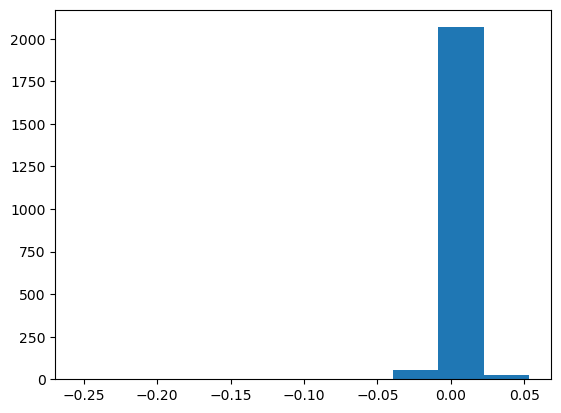

In [ ]:
plt.hist(samples['modelBias'])
# plt.scatter(samples['predDur'], samples['obs'])
# plt.scatter(results['pred'], results['obs'])

In [ ]:
x = samples['modelBias']
y = samples['humanBias']

rho,p = stats.pearsonr(x, y)
R2 = 1 - np.sum(np.square(y-x)) / np.sum(np.square(y-np.mean(y)))
modelo = sm.OLS(y, sm.add_constant(x)).fit()
print(f'Global corr = {rho:.3f}, p = {p:.3f} and global R2 is {R2:.3f}')
print('------> Linear Regression between observed and model bias: beta = {:.2f} ± {:.2f}, p = {:.3f}'
                                  .format(modelo.params[1], modelo.bse[1], modelo.f_pvalue))

Global corr = 0.014, p = 0.510 and global R2 is 0.000
------> Linear Regression between observed and model bias: beta = 50.08 ± 76.01, p = 0.510


In [ ]:
import pandas as pd
import os

# Carregando o dataframe a partir do arquivo master_dataset.xlsx
load_file = op.join(datadir, 'master_dataset.csv')
data = pd.read_csv(load_file)

# Iterando sobre as linhas do dataframe para renomear os arquivos
for index, row in data.iterrows():
    subj_id = int(row['rawSubjID'])
    run = str(int(row['run']))
    trial = str(int(row['trial']))
    veridical_duration = row['veridicalDuration']
    reported_duration = row['humanReport']

    # Construindo o novo nome do arquivo
    new_file_name = f'rGlasserTS_run{run}_trial{trial}_dur={float(reported_duration)}'

    # Renomeando o arquivo, assumindo que os arquivos estão no mesmo diretório que o script
    old_file_name = f'rGlasserTS_run{run}_trial{trial}_dur={int(veridical_duration)}' # Nome antigo dos arquivos
    old_file_path = op.join(datadir, 'extracted_voxels', str(subj_id), f'{old_file_name}.mat')
    new_file_path = op.join(datadir, 'extracted_voxels', str(subj_id), f'{new_file_name}.mat')

    # Verifica se o arquivo antigo existe antes de renomear
    if os.path.exists(old_file_path):
        os.rename(old_file_path, new_file_path)
        print(f'Arquivo renomeado: {old_file_path} -> {new_file_path}')
    else:
        print(f'Arquivo não encontrado: {old_file_path}')

print('Processo de renomeação concluído.')
